In [1]:
import os

from torch.utils.data import Dataset
import pandas as pd
import torchaudio
from torch import nn
import numpy as np
from pydub import AudioSegment
import torch
from torch.utils.data import DataLoader
import tensorflow as tf

import torch.nn.functional as F

/opt/anaconda3/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
%cd train_all_audio

/Users/ahanadeb/train_all_audio


In [3]:
SAMPLE_RATE = 64*4
NUM_SAMPLES = 64

In [4]:
from torch import nn
from torchsummary import summary


class CNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64*2*5, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        #print(input_data)
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions


if __name__ == "__main__":
    cnn = CNNNetwork()
    #summary(cnn.cuda(), (1, 64, 44))


In [15]:
class UrbanSoundDataset(Dataset):

    def __init__(self, annotations_file, audio_dir, transformation,
                 target_sample_rate,num_samples,device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.device = device
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self.transformation(signal)
        signal = self._cut_if_necessary(signal)
        signal = signal.to(self.device)
        signal = self._mix_down_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        
        return signal, label
    
    def _cut_if_necessary(self, signal):
        #print(signal.shape)
        if signal.shape[1] > self.num_samples:
            #print("cut signal")
            signal = signal[:, :self.num_samples]
        return signal
    
    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            #print(length_signal," ", self.num_samples)
            #print(signal)
            #print("right pad")
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
            #print(signal)
        return signal
    
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal
    
    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        #fold = f"fold{self.annotations.iloc[index, 5]}"
        #check_path=str(index)+".wav"
        path = os.path.join(self.audio_dir,self.annotations.iloc[
            index, 1])
        return path

    def _get_audio_sample_label(self, index):
        #print(self.annotations.iloc[index, 2])
        return self.annotations.iloc[index, 2]


if __name__ == "__main__":
    ANNOTATIONS_FILE = "annotations_sarod_flute.csv"
    AUDIO_DIR = "/Users/ahanadeb/train_all_audio"
    #SAMPLE_RATE = 2000
    #NUM_SAMPLES = 2000

    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=2048,
        hop_length=512,
        n_mels=64
    )
    
    
    usd = UrbanSoundDataset(ANNOTATIONS_FILE, AUDIO_DIR, mel_spectrogram,
                            SAMPLE_RATE,NUM_SAMPLES,device)
    print(f"There are {len(usd)} samples in the dataset.")
    signal, label = usd[0]

There are 8597 samples in the dataset.


In [18]:


BATCH_SIZE = 100
EPOCHS = 5
LEARNING_RATE = 0.001

ANNOTATIONS_FILE = "annotations_sarod_flute.csv"
AUDIO_DIR = "/Users/ahanadeb/train_all_audio"
#SAMPLE_RATE =  64*4 #22050
#NUM_SAMPLES = 64 #22050


def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader


def train_single_epoch(model, data_loader, loss_fn, optimiser, device):
    for input, target in data_loader:
        #print(target, " target")
        input, target = input.to(device), target.to(device)

        # calculate loss
        prediction = model(input)
        loss = loss_fn(prediction, target)
        #print("pred size ", prediction)
        #prediction=prediction.float()
        
        
        #target=tf.reshape(target, ([1, 1]), name=None)
        
        #target = target.unsqueeze(1)
        #target = target.float()
        
        #print("target ", target)
        #loss=    nn.BCELoss()(prediction, target)
        #target=F.one_hot(target.to(torch.int64), num_classes=2)
        #print('output.data', prediction)
        #print('torch.max(target, 1)[1]', torch.max(target, 1)[1])
        
        
        
        #loss=loss_fn(prediction, target)
        
        #print("loss ",loss)
        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"loss: {loss.item()}")


def train(model, data_loader, loss_fn, optimiser, device, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_single_epoch(model, data_loader, loss_fn, optimiser, device)
        print("---------------------------")
    print("Finished training")


if __name__ == "__main__":
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using {device}")

    # instantiating our dataset object and create data loader
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=2048,
        hop_length=512,
        n_mels=64
    )

    usd = UrbanSoundDataset(ANNOTATIONS_FILE,
                            AUDIO_DIR,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device)
    
    train_dataloader = create_data_loader(usd, BATCH_SIZE)

    # construct model and assign it to device
    cnn = CNNNetwork().to(device)
    #print(cnn)

    # initialise loss funtion + optimiser
    loss_fn = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(cnn.parameters(),
                                 lr=LEARNING_RATE)

    # train model
    train(cnn, train_dataloader, loss_fn, optimiser, device, EPOCHS)

    # save model
    torch.save(cnn.state_dict(), "feedforwardnet.pth")
    print("Trained feed forward net saved at feedforwardnet.pth")

Using cpu
Epoch 1
loss: 0.6255866885185242
---------------------------
Epoch 2
loss: 0.5983775854110718
---------------------------
Epoch 3
loss: 0.5607183575630188
---------------------------
Epoch 4
loss: 0.4932459890842438
---------------------------
Epoch 5
loss: 0.4811413884162903
---------------------------
Finished training
Trained feed forward net saved at feedforwardnet.pth


In [20]:
class_mapping = [
    "0",
    "1"
]


def predict(model, input, target, class_mapping):
    model.eval()
    with torch.no_grad():
        predictions = model(input)
        # Tensor (1, 10) -> [ [0.1, 0.01, ..., 0.6] ]
        predicted_index = predictions[0].argmax(0)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected


if __name__ == "__main__":
    # load back the model
    cnn = CNNNetwork()
    state_dict = torch.load("feedforwardnet.pth")
    cnn.load_state_dict(state_dict)

    # load urban sound dataset dataset
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=2048,
        hop_length=512,
        n_mels=64
    )

    usd = UrbanSoundDataset(ANNOTATIONS_FILE,
                            AUDIO_DIR,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            "cpu")


    # get a sample from the urban sound dataset for inference
    count=0
    for i in range(0,8597):
        input, target = usd[i][0], usd[i][1] # [batch size, num_channels, fr, time]
        input.unsqueeze_(0)

        # make an inference
        predicted, expected = predict(cnn, input, target,
                                      class_mapping)
        if(predicted==expected):
            count+=1
    print("Accuracy on train set: ", count/8597)
    #print(f"Predicted: '{predicted}', expected: '{expected}'")



Accuracy on train set:  0.8076073048737932


In [56]:
predicted==expected

True

In [47]:
#visualising the spectrograms
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt




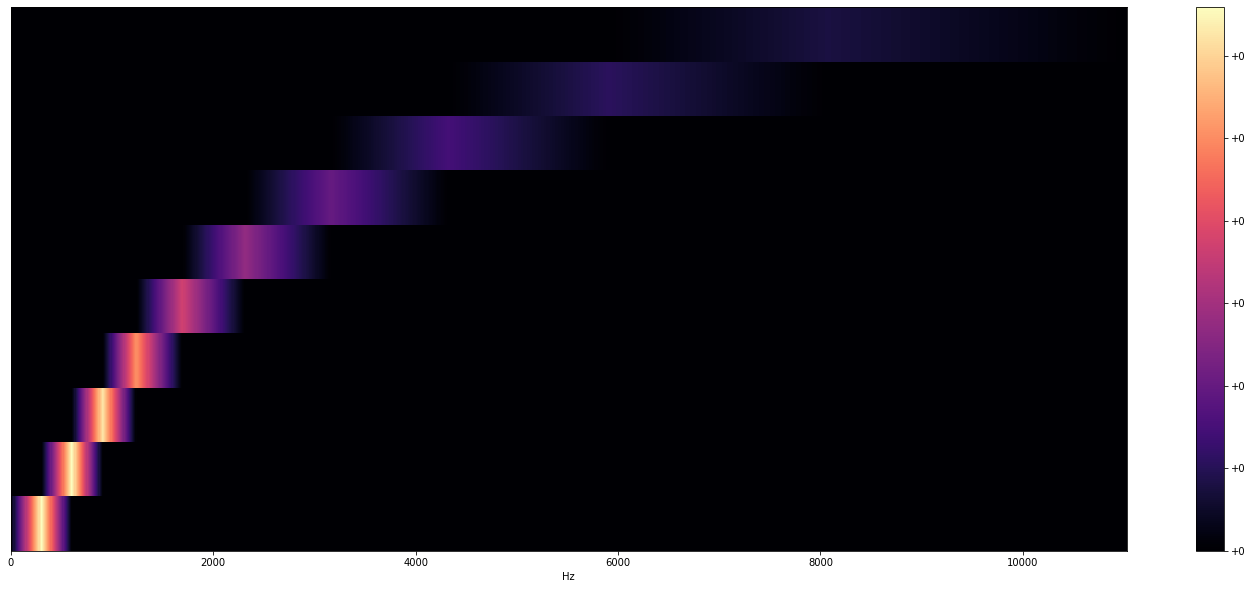

In [45]:
scale_file = "new_data/7.wav"
ipd.Audio(scale_file)
# load audio files with librosa
scale, sr = librosa.load(scale_file)
filter_banks = librosa.filters.mel(n_fft=2048, sr=22050, n_mels=10)
plt.figure(figsize=(25, 10))
librosa.display.specshow(filter_banks, 
                         sr=sr, 
                         x_axis="linear")
plt.colorbar(format="%+2.f")
plt.show()

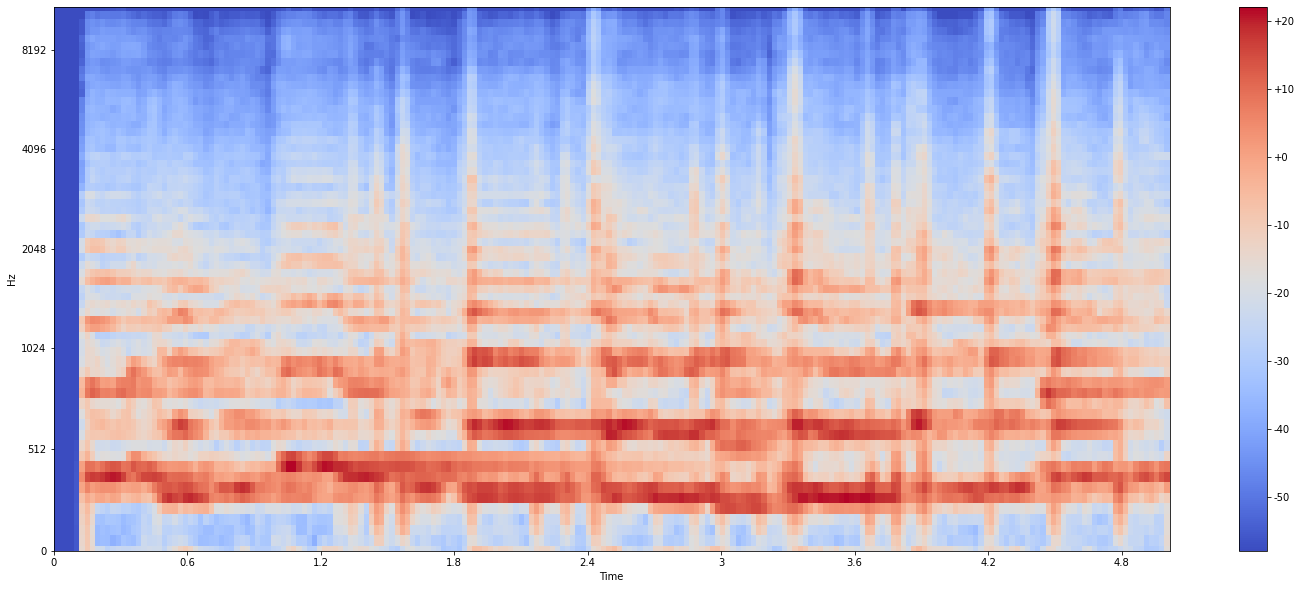

In [46]:
mel_spectrogram = librosa.feature.melspectrogram(scale, sr=sr, n_fft=2048, hop_length=512, n_mels=64)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)


plt.figure(figsize=(25, 10))
librosa.display.specshow(log_mel_spectrogram, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

